# Preamble

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Data Augmentation
import albumentations as A
# import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

# torchvision
import torchvision.transforms.v2 as TF
from torchviz import make_dot

# keep numpy use to a min
# as we store our torch.Tensors to GPU Vram but numpy in RAM (it only supports CPU)
import numpy as np
from PIL import Image
import cv2

# to have a progress bar
from tqdm import tqdm

# To use pretrained segmentation models (implement in PyTorch)
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# visualization
import matplotlib.pyplot as plt
from pprint import pprint


# OS/File/Path management
import os
import sys

# load my custom Classes/Functions/etc.
from utils.models.unet import UnetScratch
from utils.dataset import SegmentaionDataset
from utils.inferencing import inference_segmentation, img_to_inference_tensor
from utils.visualization import torch_tensor_for_plt, plot_segmentation_inference


# from utils import (
#     load_checkpoint,
#     save_checkpoint,
#     get_loaders,
#     check_accuracy,
#     save_pred_as_imgs
# )

/home/tekboart/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/tekboart/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

## Set up GPU use

In [2]:
print('PyTorch ver:', torch.__version__)

# set max_split_size_mb to avoid GPU VRAM (out of MEM error)
# Could use terminal/shell instead:
# for linux: export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# for winows: set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# force pytorch to use GPU
# use "model.to(device)" later on to force a model use Cuda GPU
print('Can I use GPU?', torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device used for calculation (CPU\Cuda):', device)

PyTorch ver: 2.0.1+cu118
Can I use GPU? True
Device used for calculation (CPU\Cuda): cuda:0


## Set Hyperparameters

In [3]:
device = device
lr = 1e-4
# due to limited Mem I values larger than 4 raise GPU MEM Error
batch_size = 16
epochs = 5
num_workers = 2
# for UNet the H/W must be a factor of 32
image_height = 384
image_width = 640
num_classes = 1
pin_mem = True
load_model = False
load_model_path = os.path.join('models')

# define path(s)
train_img_dir = os.path.join("data", "traincrop", "img")
train_mask_dir = os.path.join("data", "traincrop", "mask")
val_img_dir = os.path.join("data", "valcrop", "img")
val_mask_dir = os.path.join("data", "valcrop", "mask")

# Create Dataset

In [4]:
from utils.dataset import get_loaders, SegmentaionDataset


# define transformers (resize, rescale, augmentation, etc.)
train_transform = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # this is for z-score
        # for pretrained models on, for instance, imagenet need other values for mean and std.
        A.Normalize(mean=[0.0, 0.0, 0, 0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # TODO: this options seems risky
    # is_check_shapes=False,
)

# we don't want TTA, just some resize, normalization, etc.
val_transform = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Normalize(mean=[0.0, 0.0, 0, 0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # TODO: this options seems risky
    # is_check_shapes=False,
)


# create our datasets (with our custom Class)
train_ds = SegmentaionDataset(
    image_dir=train_img_dir,
    mask_dir=train_mask_dir,
    transform=train_transform,
    mask_suffix="",
    # subset=[0,10]
)
val_ds = SegmentaionDataset(
    image_dir=val_img_dir,
    mask_dir=val_mask_dir,
    transform=val_transform,
    mask_suffix="",
    # subset=[0,5]
)

# Create Datatset by data loaders
train_loader, val_loader = get_loaders(
    train_ds,
    val_ds,
    batch_size,
    num_workers,
    pin_mem,
)

In [5]:
# (Fast) Using Dataset's __len__ magic method (always work)
print('# train images:', len(train_ds))
print('# val images:', len(val_ds))

# (Slow) Using Data Loader (is a hit or miss)
# print('# train images:', sum(len(batch) for batch in train_loader))
# print('# val images:', sum(len(batch) for batch in val_loader))

# this outputs wrong nume (why??)
# it's not even the #imgs in mini_batch??
# print(len(train_loader))

# train images: 1896
# val images: 348


# Define Model(s)

## Import a Pretrained Segmentaion model (e.g., UNET)

In [6]:
# the downloaded model are located in "~/.cache/torch/hub/checkpoints/"
# backbone_model_name = 'resnet152'
backbone_model_name = 'mobilenet_v2'

# Segmentation model is just a PyTorch nn.Module
# model = smp.FPN(
model = smp.Unet(
    encoder_name=backbone_model_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7 
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

# load preprocessing func of the loaded model, so our data goes through the same transformation
# hint 1: it needs the input img to be in channels_last format
# hint 2: it outputs the image in channels_last format! (e.g., toch.Size[640, 360, 3])
preprocess_input = get_preprocessing_fn(backbone_model_name, pretrained='imagenet')

### Visualize the architecture

In [10]:
# the attribs of the model
# vars(model)


# plot the model arch
# create a dumy channels_first img (m, C, H, W)
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
yhat = model(x)
print(yhat.shape)

# save the architecture of the model as an image
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("./outputs/model_architecture/Unet_pretrained", format="png")

torch.Size([1, 1, 224, 224])


### Test the model with an img

## Load a Segmentation Model (i.e., UNET), written from scratch

In [6]:
model = UnetScratch(in_channels=3, num_classes=num_classes)

# Train

In [7]:
from utils.training import train_model
from utils.metrics import accuracy_segment, dice_segment

metrics = ("accuracy", "dice")
# a dict to map metrics' name to correspoing fn
metrics_fn = {
    "dice": dice_segment,
    "accuracy": accuracy_segment,
}

history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    lr=lr,
    device=device,
    metrics=metrics,
    metrics_fn=metrics_fn,
    save_model=False,
    save_checkpoint_path='./models/'
)

---------------------------------- epoch 1/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.10it/s]



accuracy:        0.93
dice:           -0.23
loss:            0.34
val_accuracy:    0.97
val_dice:        0.71
---------------------------------- epoch 2/50 ---------------------------------


100%|██████████| 119/119 [00:12<00:00,  9.21it/s]



accuracy:        0.97
dice:           -0.13
loss:            0.18
val_accuracy:    0.97
val_dice:        0.72
---------------------------------- epoch 3/50 ---------------------------------


100%|██████████| 119/119 [00:12<00:00,  9.86it/s]



accuracy:        0.97
dice:           -0.10
loss:            0.14
val_accuracy:    0.98
val_dice:        0.74
---------------------------------- epoch 4/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.03it/s]



accuracy:        0.97
dice:           -0.08
loss:            0.12
val_accuracy:    0.98
val_dice:        0.75
---------------------------------- epoch 5/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.01it/s]



accuracy:        0.97
dice:           -0.08
loss:            0.10
val_accuracy:    0.98
val_dice:        0.76
---------------------------------- epoch 6/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.28it/s]



accuracy:        0.97
dice:           -0.07
loss:            0.09
val_accuracy:    0.98
val_dice:        0.75
---------------------------------- epoch 7/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.19it/s]



accuracy:        0.97
dice:           -0.07
loss:            0.09
val_accuracy:    0.98
val_dice:        0.75
---------------------------------- epoch 8/50 ---------------------------------


100%|██████████| 119/119 [00:12<00:00,  9.19it/s]



accuracy:        0.97
dice:           -0.06
loss:            0.08
val_accuracy:    0.98
val_dice:        0.76
---------------------------------- epoch 9/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.19it/s]



accuracy:        0.97
dice:           -0.06
loss:            0.08
val_accuracy:    0.98
val_dice:        0.76
--------------------------------- epoch 10/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.22it/s]



accuracy:        0.97
dice:           -0.06
loss:            0.08
val_accuracy:    0.98
val_dice:        0.77
--------------------------------- epoch 11/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.14it/s]



accuracy:        0.97
dice:           -0.05
loss:            0.07
val_accuracy:    0.98
val_dice:        0.77
--------------------------------- epoch 12/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.17it/s]



accuracy:        0.97
dice:           -0.05
loss:            0.07
val_accuracy:    0.98
val_dice:        0.77
--------------------------------- epoch 13/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.30it/s]



accuracy:        0.97
dice:           -0.05
loss:            0.07
val_accuracy:    0.98
val_dice:        0.77
--------------------------------- epoch 14/50 ---------------------------------


100%|██████████| 119/119 [00:12<00:00,  9.26it/s]



accuracy:        0.97
dice:           -0.05
loss:            0.07
val_accuracy:    0.98
val_dice:        0.75
--------------------------------- epoch 15/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.31it/s]



accuracy:        0.97
dice:           -0.05
loss:            0.07
val_accuracy:    0.98
val_dice:        0.78
--------------------------------- epoch 16/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.11it/s]



accuracy:        0.97
dice:           -0.05
loss:            0.07
val_accuracy:    0.98
val_dice:        0.77
--------------------------------- epoch 17/50 ---------------------------------


100%|██████████| 119/119 [00:12<00:00,  9.90it/s]



accuracy:        0.97
dice:           -0.05
loss:            0.07
val_accuracy:    0.98
val_dice:        0.77
--------------------------------- epoch 18/50 ---------------------------------


100%|██████████| 119/119 [00:11<00:00, 10.17it/s]


KeyboardInterrupt: 

In [8]:
# Check pytorch.cuda GPU VRAM footprint
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 9         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  52993 KiB |   5639 MiB | 134201 MiB | 134149 MiB |
|       from large pool |  38504 KiB |   5594 MiB | 132534 MiB | 132497 MiB |
|       from small pool |  14489 KiB |     67 MiB |   1666 MiB |   1652 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  52993 KiB |   5639 MiB | 134201 MiB | 134149 MiB |
|       from large pool |  38504 KiB |   5594 MiB | 132534 MiB |

{'accuracy': [0.14375441273053488,
              0.15211860835552216,
              0.16035733620325723,
              0.16656596461931863,
              0.19934184849262238],
 'dice': [0.09389118477702141,
          0.26959826548894245,
          0.40719471375147503,
          0.45313974221547443,
          0.6022044022878011],
 'loss': [1.270665963490804,
          1.1310769319534302,
          1.0304769078890483,
          0.9726396203041077,
          0.8883387645085653],
 'val_accuracy': [0.06949788331985474,
                  0.07497639954090118,
                  0.08511312305927277,
                  0.11313069611787796,
                  0.40567547082901],
 'val_dice': [0.13689365983009338,
              0.13770438730716705,
              0.13888314366340637,
              0.14202794432640076,
              0.18109241127967834],
 'val_loss': []}


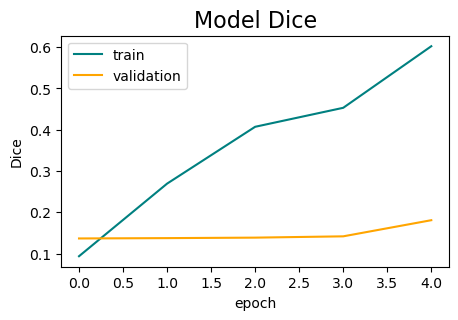

In [9]:
# print the history of evaluation metrics (during training)
pprint(history)

# plot the metrics (both train & val)
eval_metric = 'dice'
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(history[eval_metric], color='Teal', label='train')
plt.plot(history[f'val_{eval_metric}'], color='Orange', label='validation')
plt.xlabel('epoch')
plt.ylabel(eval_metric.title())
# plt.suptitle('Model Accuracy', fontsize=20)
plt.title(f'Model {eval_metric.title()}', fontsize=16)
plt.legend(loc='best')
plt.show()

# Inference

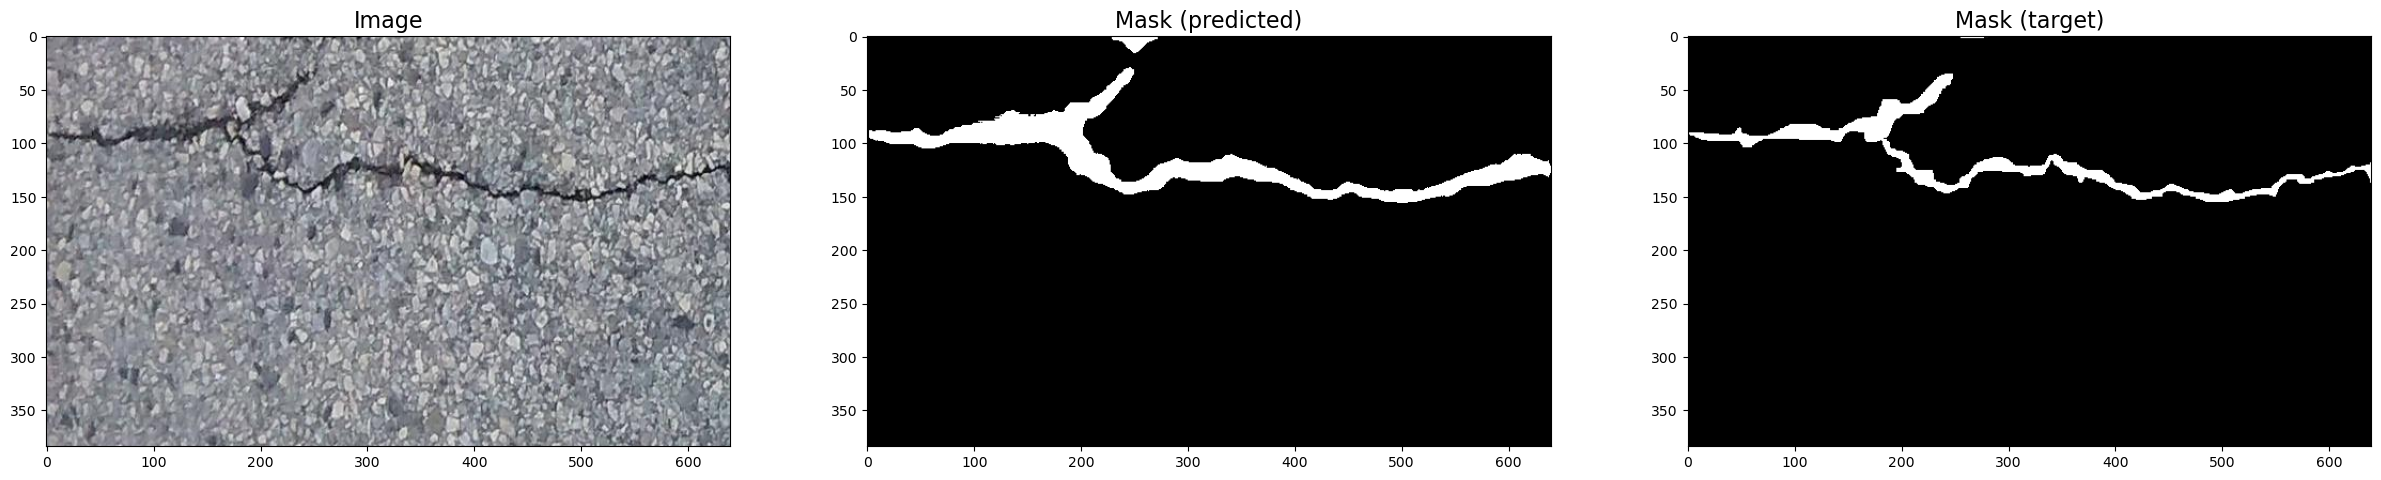

In [8]:
img_addr = os.path.join('images', '') + '20160222_081011_1_721.jpg'
mask_addr = os.path.join('images', '') + '20160222_081011_1_721_mask.png'

# inference_semantic_seg(img_addr, model=model, thresh=0.5, )

img = Image.open(img_addr).resize((image_width, image_height))
mask = Image.open(mask_addr).resize((image_width, image_height))

# normalize [-1, 1] the PIL image as a torch.Tensor
img_tensor = (TF.functional.pil_to_tensor(img) / 127.5 - 1).to(device)

yhat = model(img_tensor.unsqueeze(dim=0))
yhat_c_last = yhat[0].moveaxis(0, -1).detach().cpu().numpy()
thresh = 0.5
mask_batch = np.where(yhat_c_last >= thresh, 255, 0)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(img)
axes[0].set_title('Image', fontsize=16)
axes[1].imshow(mask_batch, cmap='gray')
axes[1].set_title('Mask (predicted)', fontsize=16)
axes[2].imshow(mask, cmap='gray')
axes[2].set_title('Mask (target)', fontsize=16)
plt.show()

In [11]:
img_addr = os.path.join('images', '') + '20160222_081011_1_721.jpg'
mask_addr = os.path.join('images', '') + '20160222_081011_1_721_mask.png'

# only for one image, if multiple use utils.dataset
test_img_batch = img_to_inference_tensor(img_addr, size=(image_height, image_width))
test_mask_batch = img_to_inference_tensor(mask_addr, size=(image_height, image_width))

# make an inference
yhat_mask = inference_segmentation(test_img_batch, model=model, normalize=True)

# make torch.Tensors ready for pyplot
test_img_batch = torch_tensor_for_plt(test_img_batch)
test_mask_batch = torch_tensor_for_plt(test_mask_batch)
yhat_mask = torch_tensor_for_plt(yhat_mask)

# plot the inference
plot_segmentation_inference(test_img_batch, test_mask_batch, yhat_mask)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

# 